Epoch [1/250] | Train Acc: 52.44% | Test Acc: 50.00% | Loss: 4.9256
Epoch [2/250] | Train Acc: 51.22% | Test Acc: 50.00% | Loss: 2.1678
Epoch [3/250] | Train Acc: 50.00% | Test Acc: 63.41% | Loss: 2.0181
Epoch [4/250] | Train Acc: 73.17% | Test Acc: 59.76% | Loss: 1.8067
Epoch [5/250] | Train Acc: 85.37% | Test Acc: 48.78% | Loss: 1.4425
Epoch [6/250] | Train Acc: 92.68% | Test Acc: 56.10% | Loss: 1.0466
Epoch [7/250] | Train Acc: 90.24% | Test Acc: 59.76% | Loss: 0.8209
Epoch [8/250] | Train Acc: 87.80% | Test Acc: 48.78% | Loss: 0.7968
Epoch [9/250] | Train Acc: 91.46% | Test Acc: 56.10% | Loss: 0.5862
Epoch [10/250] | Train Acc: 92.68% | Test Acc: 53.66% | Loss: 0.8999
Epoch [11/250] | Train Acc: 98.78% | Test Acc: 48.78% | Loss: 0.2010
Epoch [12/250] | Train Acc: 98.78% | Test Acc: 56.10% | Loss: 0.2194
Epoch [13/250] | Train Acc: 96.34% | Test Acc: 56.10% | Loss: 0.1712
Epoch [14/250] | Train Acc: 98.78% | Test Acc: 50.00% | Loss: 0.0762
Epoch [15/250] | Train Acc: 100.00% | Test 

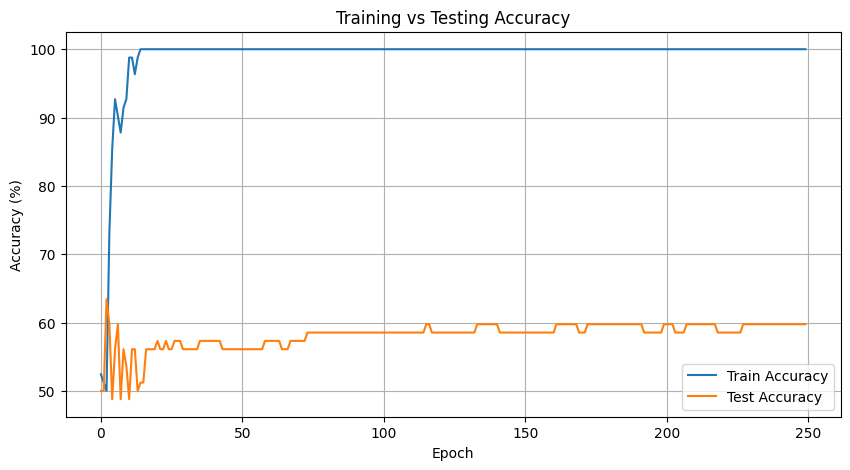

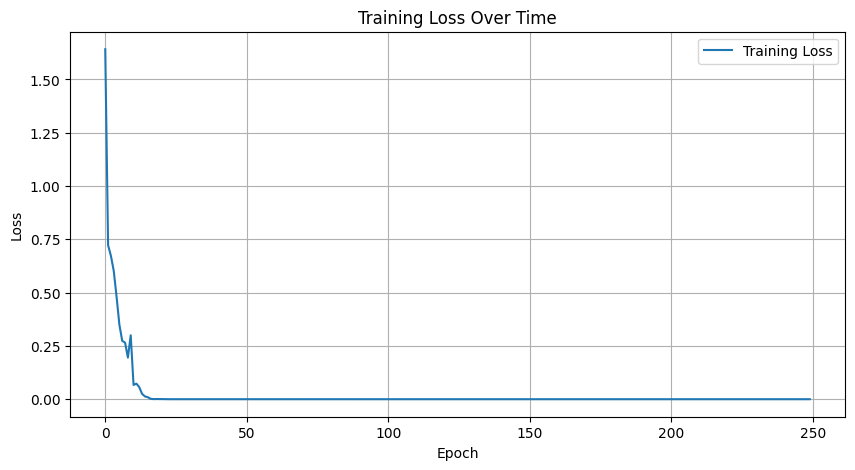

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)

# ----------------------------
# CNN Classifier
# ----------------------------
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 128x128

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64x64

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32
        )

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

# ----------------------------
# 3. Training Setup
# ----------------------------
model = CNNClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 250
train_losses = []
train_accuracies = []
test_accuracies = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Evaluation on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_acc = 100. * correct_test / total_test
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Loss: {running_loss:.4f}")

# ----------------------------
# Plot Accuracy and Loss
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()
